In [1]:
import torch
import torchvision
from diffusers import UNet2DModel
from pipeline_ddpm_custom import DDPMPipelineCustom
from scheduling_rectflow import RectFlowScheduler, RectFlowInverseScheduler
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision.transforms.functional as F
from tqdm.auto import tqdm

# Load the trained model and scheduler
model_dir = "./output/test"
unet = UNet2DModel.from_pretrained(f"{model_dir}/unet")
scheduler_config_path = os.path.join(model_dir, "scheduler", "scheduler_config.json")
scheduler = RectFlowScheduler.from_config(scheduler_config_path)
scheduler_inv = RectFlowInverseScheduler.from_config(scheduler_config_path)
if torch.cuda.is_available():
    unet.to('cuda')

# Create the pipeline
pipeline = DDPMPipelineCustom(
    unet=unet,
    scheduler=scheduler,
)
pipeline_inv = DDPMPipelineCustom(
    unet=unet,
    scheduler=scheduler_inv,
)
pipeline.set_progress_bar_config(disable=True)
pipeline_inv.set_progress_bar_config(disable=True)


/data/schu23/mldl/project/Handwriting-Beautification/diffusers/src/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'scheduling_rectflow.RectFlowScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
/data/schu23/mldl/project/Handwriting-Beautification/diffusers/src/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'scheduling_rectflow.RectFlowInverseScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-pas

In [2]:
import datasets
from torch.utils.data import DataLoader

mnist = datasets.load_dataset('ylecun/mnist')['test']
def transform(examples):
    return {
        'image': [F.to_tensor(img.resize((32, 32)).convert('RGB')) for img in examples['image']],
        'label': [label for label in examples["label"]],
    }
mnist.set_transform(transform)
mnist_loader = DataLoader(mnist, batch_size=128)
 

@torch.no_grad()
def test_reconstruction(num_inverse_steps):
    mses = []
    for batch in tqdm(mnist_loader):
        images = batch['image'].to(unet.device)
        labels = batch['label'].to(unet.device)
    
        # Run noise inversion on the given images
        semantic_noise = pipeline_inv(
            labels,
            init_noise=images * 2 - 1,
            clamp_output=False,
            num_inference_steps=num_inverse_steps,
            output_type='pt'
        ).images
    
        # reconstruction
        rec = pipeline(labels, init_noise=semantic_noise * 2 - 1, num_inference_steps=50, output_type='pt').images
        mses.extend(((images - rec) ** 2).mean(dim=[1, 2, 3]).tolist())
    return sum(mses) / len(mses)

x = [20, 50, 100, 200, 500, 1000]
y = []
for i in x:
    y.append(test_reconstruction(i))

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

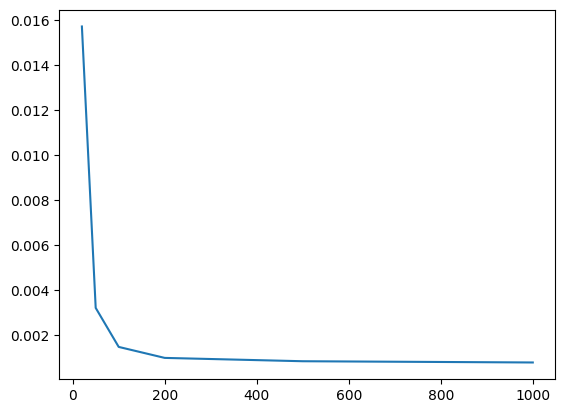

In [3]:
import matplotlib.pyplot as plt

plt.plot(x, y)